In [1]:
%matplotlib inline

import fdtd
import numpy as np
get_ipython().run_line_magic('matplotlib', 'inline')
import matplotlib.pyplot as plt
# import torch
from tqdm import tqdm_notebook as tqdm
import tifffile as tf
import os
import time
from fdtd.backend import backend as bd
from skimage.transform import rescale

from matplotlib import animation, rc
from matplotlib.colors import PowerNorm
from IPython.display import HTML

fdtd.set_backend("numpy")
# fdtd.set_backend("torch.cuda")

c = 299792458



In [2]:
def efield(grid, z=0):
    return bd.sum(grid.E, -1)[:, :, z]

def onhost(arr):
    if hasattr(arr, 'cpu'):
        return np.array(arr.cpu())
    return arr

def line_source_pointing_at_center(grid, angle=45, length=.2, dist=1):
    # length is fraction of grid height
    # distance is fraction of grid.x//2 from center
    xmid = grid.x/2
    ymid = grid.y/2
    D = dist*xmid
    L = length * grid.x
    sina = np.sin(np.deg2rad(angle))
    cosa = np.cos(np.deg2rad(angle))
    Px = xmid - sina * D
    Py = ymid - cosa * D
    L1x = Px - cosa * L/2
    L1y = Py + sina * L/2
    L2x = Px + cosa * L/2
    L2y = Py - sina * L/2
    return slice(L1x,L2x), slice(L1y,L2y)

def crop_center(img,cropx,cropy):
    y,x = img.shape
    startx = x//2-(cropx//2)
    starty = y//2-(cropy//2)    
    return img[starty:starty+cropy,startx:startx+cropx]

In [3]:

def simulate_tirf(
    total_time=100,
    dt=5,
    pixel=50e-9,
    wave=800e-9,
    angle=14,
    glass_ri = 1.55,
    medium_ri = 1.33,
    width=30e-6,
    height=20e-6,
    line_length=0.3,
    dist=1,
    pad=0.1,
    write=False,
    show=True
):

    grid = fdtd.Grid(
        shape = (height, width, 1), # 30µm x 30µm x 1 (grid_spacing) --> 2D FDTD
        grid_spacing = pixel, # 100nm "pixel" size
        permittivity = medium_ri**2,
    )

    # PML
    pad = int(pad * height/pixel)
    grid[0:pad, :, :] = fdtd.PML(name="pml_xlow")
    grid[-pad:, :, :] = fdtd.PML(name="pml_xhigh")
    grid[:, 0:pad, :] = fdtd.PML(name="pml_ylow")
    grid[:, -pad:, :] = fdtd.PML(name="pml_yhigh")

    s1, s2 = line_source_pointing_at_center(grid, angle=angle, length=line_length, dist=dist)
    grid[s1, s2, 0] = fdtd.LineSource(period=wave/299792458, name="source")
    grid[pad:grid.Nx//2, pad:grid.Ny-pad, 0] = fdtd.Object(permittivity=glass_ri**2, name="coverglass")
    grid[height/2-0.1e-6:height/2+0.4e-6, pad:width/9.5, 0] = fdtd.Object(permittivity=1e10, name="block")
    
    
    if show:
        grid.visualize(z=0)
            
    eout = []
    for t in tqdm(np.arange(0,total_time,dt)):
        grid.run(total_time=dt, progress_bar=False)
        eout.append(onhost(efield(grid, z=0)))
    return eout, grid

In [4]:
def plot_images(img_list, binsize=16, downsize=2):
    squared = img_list**2
    
    def init():
        im1.set_data(img_list[0])
        im2.set_data(intensity(0))
        return (im1, im2)

    def animate(i):
        im1.set_data(img_list[i])
        im2.set_data(intensity(i))
        return (im1, im2)
    
    def intensity(i):
        if i < binsize:
            i = squared[:i+1].mean(0)
        else:
            i = squared[i-binsize:i+1].mean(0)
        i[i.shape[0]//2, 0:i.shape[1]:2] = 0
        up=3
        center = rescale(crop_center(i,200,80), up)
        i[:center.shape[0], -center.shape[1]:] = center * 3
        return i

    ratio = np.divide(*img_list.shape[1:])
    fig = plt.figure(frameon=False, figsize=(2/ratio,1), dpi=img_list.shape[1]//downsize)
    fig.add_axes([0, 0, .5, 1])
    ax1 = fig.add_axes([0, 0, .5, 1], label='ax1')
    ax2 = fig.add_axes([.5, 0, .5, 1], label='ax2')
    ax1.axis('off')
    ax2.axis('off')
    im1 = ax1.imshow(img_list[0], cmap='bwr', vmin=-0.008, vmax=0.008)
    im2 = ax2.imshow(intensity(0), cmap='cubehelix', norm=PowerNorm(gamma=0.9), vmin=0, vmax=2.9e-05)
    anim = animation.FuncAnimation(fig, animate, init_func=init,
                                   frames=tqdm(range(len(img_list))), interval=100, blit=True)

    return anim

# Set up formatting for the movie files
Writer = animation.writers['ffmpeg']
writer = Writer(fps=20, metadata=dict(artist='Talley Lambert'),
                codec="libx264", extra_args=['-pix_fmt', 'yuv420p'],
                bitrate=1800)

# anim = plot_images(eout[150:300], downsize=1)
# anim.save(f'tirf_{wave*1e9}nm_{90-angle}deg.mp4', writer=writer)

# HTML(anim.to_html5_video())

In [5]:
def plot_phase(img_list, binsize=16, downsize=2):

    def animate(i):
        im1 = ax1.imshow(img_list[i], cmap='bwr', vmin=-0.008, vmax=0.008)
        return (im1,)
    
    fig = plt.figure(frameon=False, figsize=(15,10))
    ax1 = fig.add_axes([0, 0, 1, 1], label='ax1')
    ax1.axis('off')
    im1 = ax1.imshow(img_list[0], cmap='bwr', vmin=-0.008, vmax=0.008)
    anim = animation.FuncAnimation(fig, animate,
                                   frames=tqdm(range(len(img_list))),
                                   interval=100, blit=True)

    return anim

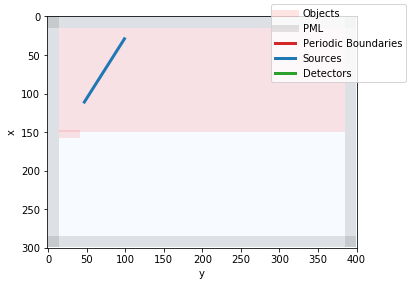

In [6]:

wv = 800e-9
angle=32
eout,grid = simulate_tirf(
    total_time=400, dt=20, pixel=50e-9, 
    width=20e-6, height=15e-6,
    dist=1, pad = 0.05,
    wave=wv, angle=angle, line_length=0.33
)
eout = np.stack(eout).astype(np.float32)


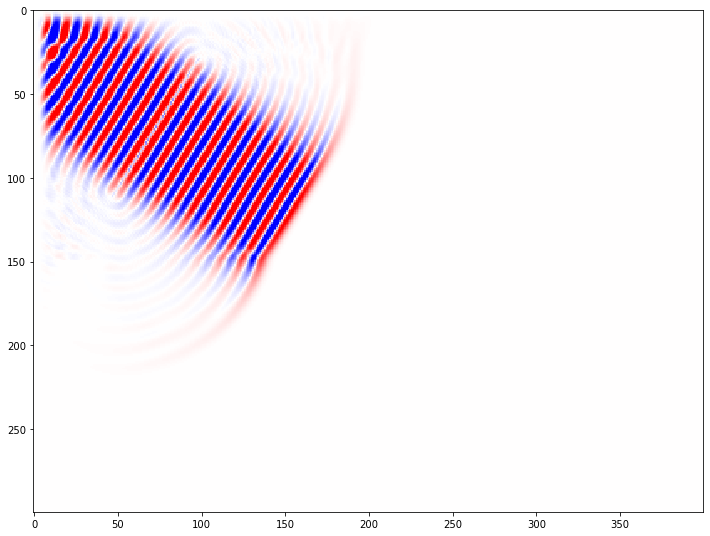

In [7]:
# eout = np.fliplr(np.stack(eout).astype(np.float32))
# tf.imsave(f'tirf_{int(wv*1e9)}nm_{90-angle}deg.tif', eout)
# anim = plot_phase(eout)

# mm = 10000000000000000000000000000000000000000
plt.figure(figsize=(12,12))
plt.imshow(eout[10],  vmin=-0.008, vmax=0.008, cmap='bwr')

76


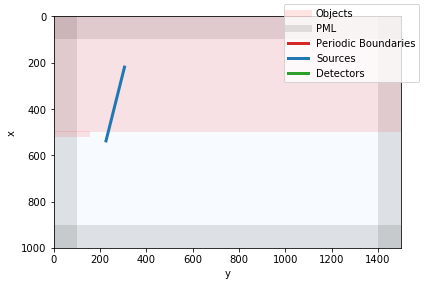

KeyboardInterrupt: 

In [56]:
# Set up formatting for the movie files
Writer = animation.writers['ffmpeg']
writer = Writer(fps=20, metadata=dict(artist='Talley Lambert'),
                codec="libx264", extra_args=['-pix_fmt', 'yuv420p'],
                bitrate=1800)

wv = 800e-9
for angle in np.arange(14,44,2):
    try:
        print(90-angle)
        eout,grid = simulate_tirf(total_time=4000, dt=10, pixel=20e-9, wave=wv, angle=angle, line_length=0.33,)
        eout = np.fliplr(np.stack(eout).astype(np.float32))
        tf.imsave(f'tirf_{int(wv*1e9)}nm_{90-angle}deg.tif', eout)
        anim = plot_images(eout, downsize=1)
        anim.save(f'tirf_{int(wv*1e9)}nm_{90-angle}deg.mp4', writer=writer)
    except Exception as e:
        raise
        print(f"angle {angle} errored")
